In [7]:
import numpy as np
import pdb
import ChiantiPy.core as ch
import matplotlib.pyplot as plt
import ChiantiPy.tools.filters as chfilters
import astropy.io.fits
from scipy.ndimage import uniform_filter

In [8]:
#Parameters
# CGS
NM_TO_ANGSTROM = 10
AU = 1.5e13
PC = 3.086e18
h = 6.626e-27
c = 3e10
k_B = 1.38e-16
CM_TO_ANG = 1e8
Lsun = 3.828e33


# HD209458
corona_temp = 1e6
corona_density = 1e9 # atoms/cm3 
total_X_ray_flux = 0.5689 # ergs/s*cm2, at 1AU, Lx = 1.6e27 ergs/s Czesla/Salz 2017
lyman_flux = 20.94 # L log 28.77 Salz 2016
dist = 48.3 * PC
T_eff = 6026
R = 1.2 * 7e10
luminosity = 1.702



#TOI 1430
#corona_temp = 4e6
# corona_density = 1e9
# total_X_ray_flux = 8
# lyman_flux = 23
# dist = 41.2 * PC
# T_eff = 5067
# R = 0.78 * 7e10
# Lsun = 3.828e33
# luminosity = 0.365

# #HD 63433
# corona_temp = 4e6
# corona_density = 1e9
# total_X_ray_flux = 38 #at 1 AU, based on ROSAT
# lyman_flux = 56
# dist = 22.4 * PC
# T_eff = 5670
# R = 0.912 * 7e10
# Lsun = 3.828e33
# luminosity = 0.75


#55 Cnc
# corona_temp = 2e6
# corona_density = 1e10
# total_X_ray_flux = 0.158 #at 1 AU, averaging two XMM measurements
# lyman_flux = 4
# T_eff = 5250
# R = 0.964 * 7e10
# luminosity = 0.64

#TOI 560
# corona_temp = 4e6
# corona_density = 1e9
# total_X_ray_flux = 19 #at 1 AU, based on ROSAT
# lyman_flux = 15
# dist = 31.6 * PC
# T_eff = 4630
# R = 0.665 * 7e10
# luminosity = 0.183

In [9]:
temperature = [corona_temp]
density = [corona_density]
wvl = np.arange(4, 101, 0.05) 
emeasure = [1e27] #irrelevant, we'll normalize it out

s = ch.spectrum(temperature, density, wvl, filter = (chfilters.gaussian,.2), em = emeasure, doContinuum=1, minAbund=1.e-6)

 elapsed seconds =      278.000


In [10]:
all_wavelengths = []
all_fluxes = []

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


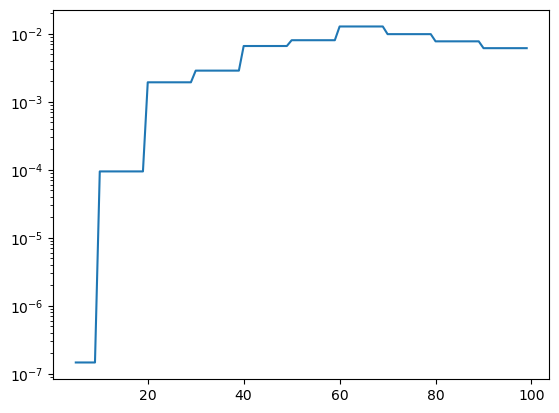

In [11]:
#Add X-ray part of spectrum, Chianti

chianti_spectrum = s.Spectrum['intensity']
norm_factor = total_X_ray_flux / np.trapz(chianti_spectrum, wvl)

bin_size = 10
lower_edges = np.arange(0, 100, bin_size)
upper_edges = bin_size + lower_edges
lower_edges[0] = 5 #min wavelength

for i in range(len(lower_edges)):
    cond = np.logical_and(wvl >= lower_edges[i], wvl < upper_edges[i])   
    all_wavelengths += list(np.arange(lower_edges[i], upper_edges[i]))
    all_fluxes += (upper_edges[i] - lower_edges[i]) * [norm_factor * np.mean(chianti_spectrum[cond])]

#plt.semilogy(midpoints, binned_spectrum) 
plt.semilogy(all_wavelengths, all_fluxes)
print(all_wavelengths)

0.5608247461789643


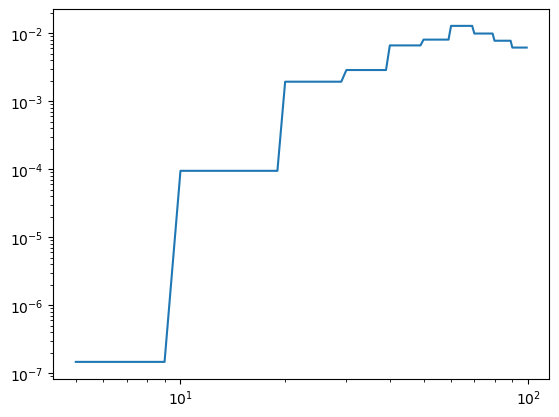

In [12]:
plt.loglog(all_wavelengths, all_fluxes)
print(np.trapz(all_fluxes, all_wavelengths))

(9, 2)
17.44668739224435


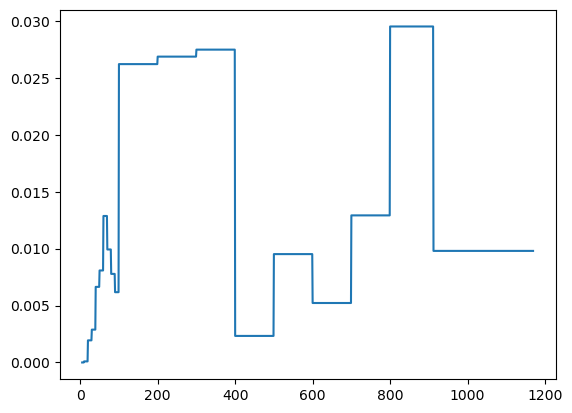

In [13]:
wavelength_bins = NM_TO_ANGSTROM * np.array([
    [10, 20],
    [20, 30],
    [30, 40],
    [40, 50],
    [50, 60],
    [60, 70],
    [70, 80],
    [80, 91.2],
    [91.2, 117]])
print(wavelength_bins.shape)

wavelengths = np.array([(b[0] + b[1])/2 for b in wavelength_bins])
offsets = np.array([-1.357, -1.3, -0.882, -2.294, -2.098, -1.92, -1.894, -1.811, -1.004])
slopes = np.array([0.344, 0.309, 0, 0.258, 0.572, 0.240, 0.518, 0.764, 0.065])

ratios = 10**(offsets + slopes * np.log10(lyman_flux))
#print(ratios)

for i in range(len(ratios)):
    bin_width = wavelength_bins[i][1] - wavelength_bins[i][0]

    #erg/s/cm^2/A
    F_earth = ratios[i] * lyman_flux / bin_width
    per_A_wavelengths = np.arange(wavelength_bins[i][0], wavelength_bins[i][1], 1)
    all_wavelengths += list(per_A_wavelengths)
    all_fluxes += len(per_A_wavelengths) * [F_earth]

plt.plot(all_wavelengths, all_fluxes)

print(np.trapz(all_fluxes, all_wavelengths))

20.930667671911586


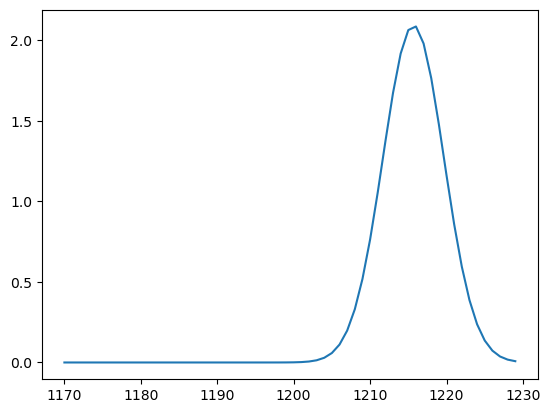

In [14]:
#Now add in reconstructed Ly alpha line
center = 1215.67
width = 9.4 / 2.355
A = lyman_flux / (np.sqrt(2 * np.pi) * width)
wavelengths = np.arange(all_wavelengths[-1] + 1, 1230)
profile = A * np.exp(-(wavelengths - center)**2/2/width**2)
plt.plot(wavelengths, profile)

print(np.trapz(profile, wavelengths))

all_wavelengths += list(wavelengths)
all_fluxes += list(profile)

1.0158739487401285


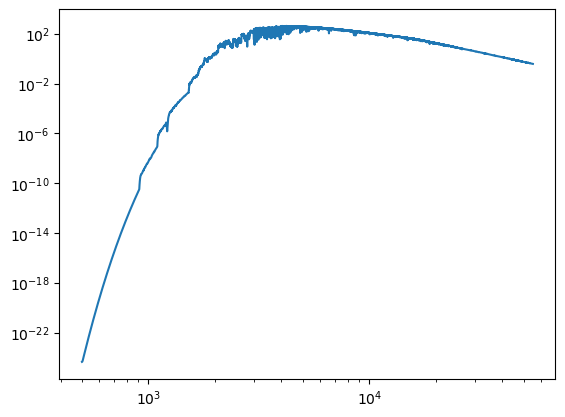

In [15]:
wavelengths = astropy.io.fits.open("hd209458_WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")[0].data
hdul = astropy.io.fits.open("hd209458_spectrum.fits")

spectrum = hdul[0].data * (R/AU)**2 / CM_TO_ANG
inferred_luminosity = np.trapz(spectrum, wavelengths) * 4*np.pi*AU**2
print(luminosity * Lsun / inferred_luminosity)
spectrum *= (luminosity * Lsun / inferred_luminosity)
spectrum = uniform_filter(spectrum, 110)

plt.loglog(wavelengths, spectrum)

binned_wavelengths = np.arange(all_wavelengths[-1] + 1, max(wavelengths), 10)
all_wavelengths += list(binned_wavelengths)
all_fluxes += list(np.interp(binned_wavelengths, wavelengths, spectrum))

[0.42915569]


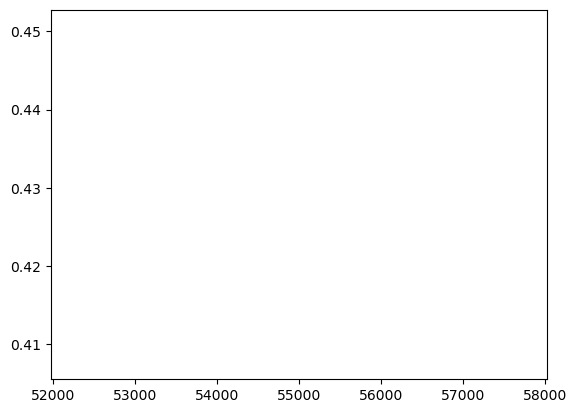

In [16]:
max_wavelength = 55000 #Angstroms

binned_wavelengths = np.arange(all_wavelengths[-1] + 1, max_wavelength, 10)
bb_fluxes = np.pi*2*h*c**2/(binned_wavelengths / CM_TO_ANG)**5 / (np.exp(h*c/(binned_wavelengths / CM_TO_ANG)/k_B/T_eff) - 1) * (R/AU)**2 / CM_TO_ANG

all_wavelengths += list(binned_wavelengths)
all_fluxes += list(bb_fluxes)

print(bb_fluxes)
plt.plot(binned_wavelengths, bb_fluxes)

Text(0.5, 0, 'Wavelength ($\\AA$)')

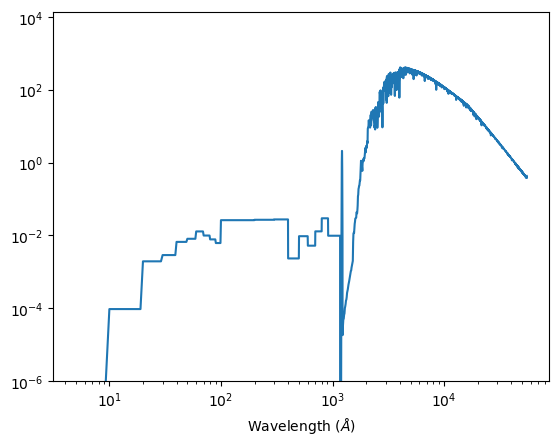

In [17]:
all_wavelengths = np.array(all_wavelengths)
all_fluxes = np.array(all_fluxes)
#plt.figure(figsize=(16,10))
plt.loglog(all_wavelengths, all_fluxes)
plt.ylim(1e-6)
#plt.xlim(1210, 1300)
plt.xlabel("Wavelength ($\AA$)")

In [18]:
np.trapz(all_fluxes, all_wavelengths) * (4*np.pi*AU**2)/3.828e33

1.7031610937215844

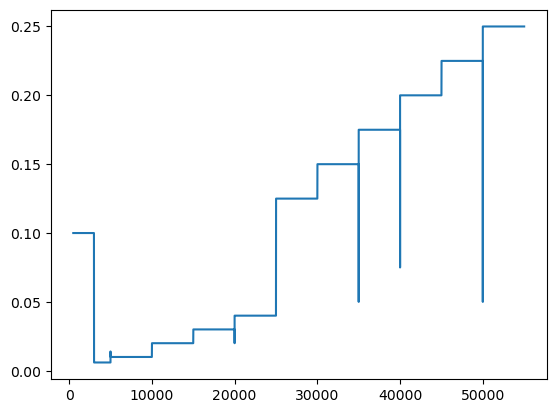

In [19]:
plt.plot(wavelengths[1:], np.diff(wavelengths))

In [20]:
output_filename = "hd209458_extended_spectrum_xspec"
with open(output_filename, "w") as f:
    for i in range(len(all_wavelengths)):
        f.write("{} {}\n".format(all_wavelengths[i], all_fluxes[i]))
        
        

(-20.0, -6.794214680027341)

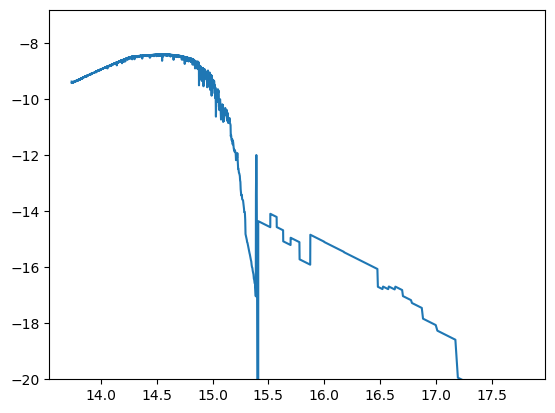

In [21]:
c = 3e10
frequencies = c / (all_wavelengths / CM_TO_ANG)
spec_freq = (all_fluxes * CM_TO_ANG) * (all_wavelengths / CM_TO_ANG)**2 / c
#spec_freq[all_wavelengths < 1250] = 1e-23

frequencies = frequencies[::-1]
spec_freq = spec_freq[::-1]

plt.plot(np.log10(frequencies), np.log10(spec_freq))
plt.ylim(-20,)

In [25]:
# Print CSV
import csv

with open("hd209458_extended_spectrum_w.csv", "w") as f:
    writer = csv.writer(f)
    for i in range(len(frequencies)):
        writer.writerow([all_wavelengths[i], all_fluxes[i]])


In [23]:
#Print TPCI initialization



with open("hd209458_spectrum.ini", "w") as f:
    f.write("interpolate\n")
    for i in range(len(frequencies)):
        f.write("continue {} {}\n".format(np.log10(frequencies[i]), np.log10(spec_freq[i])))
    f.write("luminosity solar {} linear\n".format(luminosity))